In [1]:
%load_ext autoreload
%autoreload 2

In [73]:
from transformer_lens import HookedTransformer
import random
import sys
import os
import collections
import operator

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)
from pyfunctions.general import compare_same
from pyfunctions.cdt_basic import *
from pyfunctions.cdt_source_to_target import *
from pyfunctions.cdt_from_source_nodes import *
from pyfunctions.toy_model import *
import seaborn as sns
import matplotlib.pyplot as plt

import torch

In [3]:
# from mi_utils_public import *
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.autograd.set_grad_enabled(False)
model = HookedTransformer.from_pretrained('attn-only-4l',
                                         fold_ln=False)
model.cfg.use_attn_result = False # what does this do?
"""Toggle whether to explicitly calculate and expose the result for each attention head.
Useful for interpretability but can easily burn through GPU memory.
        """
# because running subprocess breaks things
# %env TOKENIZERS_PARALLELISM=true



/accounts/projects/binyu/georgiasimpression/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- 

Loaded pretrained model attn-only-4l into HookedTransformer


'Toggle whether to explicitly calculate and expose the result for each attention head.\nUseful for interpretability but can easily burn through GPU memory.\n        '

In [115]:
print(model)

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (ln_final): LayerNorm(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (unembed): Unembed()
)


In [4]:

from im_utils.prompts import Prompt, docstring_ind_prompt_gen

batch_size = 50

docstring_ind_prompt_kwargs = dict(
    n_matching_args=3,
    n_def_prefix_args=2,
    n_def_suffix_args=1,
    n_doc_prefix_args=0,
    met_desc_len=3,
    arg_desc_len=2
)
prompts = [docstring_ind_prompt_gen("rest", **docstring_ind_prompt_kwargs) for _ in range(batch_size)]

In [5]:
tokens = model.to_str_tokens(prompts[0].clean_prompt)


In [6]:
pos_labels = model.to_str_tokens(prompts[0].clean_prompt)
pos_labels[ 0] = "BOS"
pos_labels[ 1] = "⏎"
pos_labels[ 2] = "def"
pos_labels[ 3] = "rand0"
pos_labels[ 4] = "("
pos_labels[ 5] = "self"
pos_labels[ 6] = ",_0"
pos_labels[ 7] = "rand1"
pos_labels[ 8] = ",_1"
pos_labels[ 9] = "rand2"
pos_labels[10] = ",_2"
pos_labels[11] = "A_def"
pos_labels[12] = ",_A"
pos_labels[13] = "B_def"
pos_labels[14] = ",_B"
pos_labels[15] = "C_def"
pos_labels[16] = ",_C"
pos_labels[17] = "rand3"
pos_labels[18] = "):"
pos_labels[19] = "⏎···_0"
pos_labels[20] = '"""'
pos_labels[21] = "rand4"
pos_labels[22] = "rand5"
pos_labels[23] = "rand6"
pos_labels[24] = "⏎⏎···_1"
pos_labels[25] = "·:_0"
pos_labels[26] = "param_1"
pos_labels[27] = "A_doc"
pos_labels[28] = ":_1"
pos_labels[29] = "rand7"
pos_labels[30] = "rand8"
pos_labels[31] = "⏎···_2"
pos_labels[32] = "·:_1"
pos_labels[33] = "param_2"
pos_labels[34] = "B_doc"
pos_labels[35] = ":_2"
pos_labels[36] = "rand9"
pos_labels[37] = "rand10"
pos_labels[38] = "⏎···_3"
pos_labels[39] = "·:_2"
pos_labels[40] = "param_3"

In [22]:
# dir(prompts[0])
'''
'clean_prompt',
 'correct_answers',
 'corrupt_prompt',
 'print_all_corrupt',
 'print_all_corrupt_tokenized',
 'print_clean',
 'print_clean_tokenized',
 'print_corrupt',
 'print_corrupt_tokenized',
 'print_tokenized',
 'wrong_answers'
'''

print(prompts[0].clean_prompt)
# 'random_doc', 'random_def', 'random_answer', 'random_def_doc', 'random_answer_doc', 'random_random', 'vary_length_doc_desc', 'vary_length_doc_desc_random_doc'
# print(prompts[0].corrupt_prompt.keys())
# type(prompts[0])
# These are actually decently well explained in the original LessWrong post, I just didn't see it at first.
print(prompts[0].corrupt_prompt['random_doc'])
print(prompts[0].corrupt_prompt['random_def_doc'])
print(prompts[0].corrupt_prompt['random_answer_doc'])
print(prompts[0].corrupt_prompt['random_random'])
print(prompts[0].corrupt_prompt['vary_length_doc_desc'])
print(prompts[0].corrupt_prompt['vary_length_doc_desc_random_doc'])



def msg(self, description, status, call):
    """choice minute sort

    :param description: drug machine
    :param status: ground register
    :param

def msg(self, description, status, call):
    """choice minute sort

    :param state: drug machine
    :param server: ground register
    :param

def msg(self, state, server, call):
    """choice minute sort

    :param state: drug machine
    :param server: ground register
    :param

def msg(self, description, status, option):
    """choice minute sort

    :param state: drug machine
    :param server: ground register
    :param

def msg(self, filename, valid, host):
    """choice minute sort

    :param name: drug machine
    :param index: ground register
    :param

def msg(self, description, status, call):
    """choice minute sort

    :param description: drug
    :param status: ground machine register
    :param

def msg(self, description, status, call):
    """choice minute sort

    :param state: drug
    :param server: grou

In [162]:
logits, cache = model.run_with_cache(prompts[0].clean_prompt)
tokens = model.to_tokens(prompts[0].clean_prompt).to(device)
# logits, cache = model.run_with_cache(tokens)
for activation_name, activation in cache.items():
    # Only print for first layer
    if ".0." in activation_name or "blocks" not in activation_name:
        print(f"{activation_name:30} {tuple(activation.shape)}")

hook_embed                     (1, 35, 512)
hook_pos_embed                 (1, 35, 512)
blocks.0.hook_resid_pre        (1, 35, 512)
blocks.0.ln1.hook_scale        (1, 35, 1)
blocks.0.ln1.hook_normalized   (1, 35, 512)
blocks.0.attn.hook_q           (1, 35, 8, 64)
blocks.0.attn.hook_k           (1, 35, 8, 64)
blocks.0.attn.hook_v           (1, 35, 8, 64)
blocks.0.attn.hook_attn_scores (1, 8, 35, 35)
blocks.0.attn.hook_pattern     (1, 8, 35, 35)
blocks.0.attn.hook_z           (1, 35, 8, 64)
blocks.0.hook_attn_out         (1, 35, 512)
blocks.0.hook_resid_post       (1, 35, 512)
ln_final.hook_scale            (1, 35, 1)
ln_final.hook_normalized       (1, 35, 512)


In [158]:
compare_same(cache['blocks.1.hook_resid_pre'], cache['blocks.0.hook_resid_post'])

100.00% of the values are equal


1.0

In [25]:
encoding = model.tokenizer.encode_plus(prompts[0].clean_prompt, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 # prepend_bos=True, # currently dealing with this: make sure BOS prepend matches because currently the sequence lengths are off-by-one
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask

# god help us if we want to make HF prepend the BOS token, which this model expects
# so do it ourselves manually
attention_mask = torch.tensor([[1] + attention_mask.cpu().numpy().tolist()[0]], device=device)
encoding_idxs = torch.tensor([[1] + encoding_idxs.cpu().numpy().tolist()[0]], device=device)
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)

/accounts/projects/binyu/georgiasimpression/.local/lib/python3.12/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [175]:
in_0 = cache['blocks.0.hook_resid_pre']
compare_same(cache['hook_embed'] + cache['hook_pos_embed'], cache['blocks.0.hook_resid_pre'])

# Ensure that the encodings are the same (they won't be if you set prepend_bos=True for one and not the other!)
# print(tokens)
# print(encoding.input_ids)

# Note that model.embed alone isn't the same thing as what we might normally call "the embedding"!
embedding_output = model.embed(encoding_idxs) + model.pos_embed(encoding_idxs)
compare_same(in_0, embedding_output, atol=1e-8, rtol=1e-6)

100.00% of the values are equal
100.00% of the values are equal


1.0

In [136]:

att_probs = prop_toy_model_4l_layer(torch.zeros_like(in_0), embedding_output, extended_attention_mask, None, 
                  {}, [], 0, None,
                  model.blocks[0], device, att_probs = None, set_irrel_to_mean=False, target_decomp_method="residual")
compare_same(att_probs, cache['blocks.0.attn.hook_pattern'])
# print(type(att_probs))

100.00% of the values are equal


1.0

In [142]:
# now check correctness of prop implementation
rel, irrel, _, _ = prop_toy_model_4l_layer(torch.zeros_like(in_0), embedding_output, extended_attention_mask, None, 
                  {}, [], 0, None,
                  model.blocks[0], device, att_probs = None, set_irrel_to_mean=False, target_decomp_method="residual")
output_layer_0 = rel + irrel

In [177]:
compare_same(output_layer_0, cache['blocks.1.hook_resid_pre'], atol=1e-4)
# print(type(desired_output_layer_0))
# compare_same(output_layer_0, cache['blocks.1.hook_resid_pre'], atol=1e-6, rtol=1e-5) # numerical error accumulation is significant for this model compared to gpt-2, wonder why?


99.99% of the values are equal


0.9999441964285715

In [167]:
out_a_ln = prop_toy_model_4l(encoding_idxs,
            extended_attention_mask,
            model,
            [(Node(0, 0, 0),)],
            [],
            device,
            mean_acts = None,
            att_list = None,
            set_irrel_to_mean=False
)

In [168]:
compare_same(cache['ln_final.hook_normalized'], out_a_ln)

99.66% of the values are equal


0.9965959821428572

In [165]:
out_decomps, _, _, _ = prop_toy_model_4l(encoding_idxs,
            extended_attention_mask,
            model,
            [(Node(0, 0, 0),)],
            [],
            device,
            mean_acts = None,
            att_list = None,
            set_irrel_to_mean=False
)
output_total = out_decomps[0].rel + out_decomps[0].irrel

In [156]:
print(logits.shape)

torch.Size([1, 35, 48262])


In [173]:
compare_same(output_total, logits, atol=1) # error accumulated approaches 1e-4 in absolute value.


100.00% of the values are equal


0.999997039966374

In [180]:
print(prompts[0].clean_prompt)


def user(self, node, ret, order, version, read, settings):
    """export chemical plate

    :param order: trip miss
    :param version: strength scale
    :param


In [43]:
text = prompts[0].clean_prompt
tokens = model.to_tokens(text).to(device)
logits, cache = model.run_with_cache(text)
probs = logits.softmax(dim=-1)
most_likely_next_tokens = model.tokenizer.batch_decode(logits.argmax(dim=-1)[0])

In [50]:
print(probs[0, -1, model.to_single_token(tokens[pos_labels.index("C_def")])])

tensor(0.4272, device='cuda:0')


In [45]:
print(most_likely_next_tokens)

['.', 'The', ' get', '_', 'request', ',', ' resource', '):', ' name', '=', ' name', '=', ' **', "='", ' name', ',', ' status', '):', '\n   ', ' """', '\n   ', 's', '.', '.', ' @', 'param', ' fields', ':', ' The', ' value', ' for', ' :', 'param', ' action', ':', ' the', ' stand', '\n   ', ' :', 'param', ' status']


In [30]:
print(prompts[0].clean_prompt)


def resource(self, fields, shape, last, action, status, info):
    """trust worker register

    :param last: dollar stand
    :param action: currency program
    :param


In [35]:
prompt_idx = 0

In [36]:
example_prompt = prompts[prompt_idx].clean_prompt
tokens = model.to_str_tokens(example_prompt)

example_answer = tokens[pos_labels.index("C_def")]
print(example_prompt)
print(example_answer)
transformer_lens.utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)


def resource(self, fields, shape, last, action, status, info):
    """trust worker register

    :param last: dollar stand
    :param action: currency program
    :param
 status
Tokenized prompt: ['<|BOS|>', '\n', 'def', ' resource', '(', 'self', ',', ' fields', ',', ' shape', ',', ' last', ',', ' action', ',', ' status', ',', ' info', '):', '\n   ', ' """', 'trust', ' worker', ' register', '\n\n   ', ' :', 'param', ' last', ':', ' dollar', ' stand', '\n   ', ' :', 'param', ' action', ':', ' currency', ' program', '\n   ', ' :', 'param']
Tokenized answer: [' status']


Performance on answer token:
Rank: 0        Logit: 18.43 Prob: 42.72% Token: | status|

Top 0th token. Logit: 18.43 Prob: 42.72% Token: | status|
Top 1th token. Logit: 16.01 Prob:  3.81% Token: | action|
Top 2th token. Logit: 16.01 Prob:  3.80% Token: | value|
Top 3th token. Logit: 15.99 Prob:  3.71% Token: | name|
Top 4th token. Logit: 15.59 Prob:  2.50% Token: | type|
Top 5th token. Logit: 15.41 Prob:  2.08% Token: | description|
Top 6th token. Logit: 15.21 Prob:  1.70% Token: |:|
Top 7th token. Logit: 15.05 Prob:  1.46% Token: | date|
Top 8th token. Logit: 15.04 Prob:  1.44% Token: | body|
Top 9th token. Logit: 14.89 Prob:  1.24% Token: | data|


Ranks of the answer tokens: [(' status', 0)]

In [12]:

num_layers = len(model.blocks)
seq_len = len(pos_labels)
num_attention_heads = model.cfg.n_heads

In [13]:
corrupt_prompt = prompts[prompt_idx].corrupt_prompt['random_answer_doc']

# corrupt_tokens = model.to_str_tokens(corrupt_prompt)
corrupt_logits, corrupt_cache = model.run_with_cache(corrupt_prompt)
corrupt_attention_outputs = [corrupt_cache['blocks.' + str(i) + '.attn.hook_z'] for i in range(num_layers)]
corrupt_attention_outputs = torch.stack(corrupt_attention_outputs, dim=1).squeeze(0) # now layer, seq, n_heads, dim_attn (squeezed away the batch dim)
old_shape = corrupt_attention_outputs.shape
last_dim = old_shape[-2] * old_shape[-1]
new_shape = old_shape[:-2] + (last_dim,)
corrupt_attention_outputs = corrupt_attention_outputs.view(new_shape)

In [46]:
corrupt_attention_outputs.shape
# corrupt_logits.shape

torch.Size([4, 41, 512])

In [14]:
import itertools
import functools
encoding = model.tokenizer.encode_plus(prompts[prompt_idx].clean_prompt, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 # prepend_bos=True, # currently dealing with this: make sure BOS prepend matches because currently the sequence lengths are off-by-one
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask

# god help us if we want to make HF prepend the BOS token, which this model expects
# so do it ourselves manually
attention_mask = torch.tensor([[1] + attention_mask.cpu().numpy().tolist()[0]], device=device)
encoding_idxs = torch.tensor([[1] + encoding_idxs.cpu().numpy().tolist()[0]], device=device)
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)

ranges = [
        [layer for layer in range(num_layers)],
        [sequence_position for sequence_position in range(seq_len)],
        [attention_head_idx for attention_head_idx in range(num_attention_heads)]
]
source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

target_nodes = []

# cache activations for faster batch run
# out_decomp, _, _, pre_layer_activations = prop_toy_model_4l(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=corrupt_attention_outputs, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_toy_model_4l(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=corrupt_attention_outputs, set_irrel_to_mean=True)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)

/accounts/projects/binyu/georgiasimpression/.local/lib/python3.12/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Running inputs 0 to 64 (of 1312)
Running inputs 64 to 128 (of 1312)
Running inputs 128 to 192 (of 1312)
Running inputs 192 to 256 (of 1312)
Running inputs 256 to 320 (of 1312)
Running inputs 320 to 384 (of 1312)
Running inputs 384 to 448 (of 1312)
Running inputs 448 to 512 (of 1312)
Running inputs 512 to 576 (of 1312)
Running inputs 576 to 640 (of 1312)
Running inputs 640 to 704 (of 1312)
Running inputs 704 to 768 (of 1312)
Running inputs 768 to 832 (of 1312)
Running inputs 832 to 896 (of 1312)
Running inputs 896 to 960 (of 1312)
Running inputs 960 to 1024 (of 1312)
Running inputs 1216 to 1280 (of 1312)
Running inputs 1280 to 1312 (of 1312)


In [46]:
print(logits[0, -1, pos_labels.index("C_def")])

tensor(10.0328, device='cuda:0')


In [56]:
# just a check
output = out_decomps[0].rel + out_decomps[0].irrel
tokens = model.to_str_tokens(text)

# print(tokens.shape)
correct_logit_idx = model.to_single_token(tokens[pos_labels.index("C_def")])
correct_logit = output[0, -1, correct_logit_idx]
incorrect_seq_idxs = [pos_labels.index("A_def"), pos_labels.index("B_def"),
                 pos_labels.index("rand0"),
                 pos_labels.index("rand1"),
                 pos_labels.index("rand2"),
                 pos_labels.index("rand3"),
                 pos_labels.index("rand4"),
                 pos_labels.index("rand5"),
                 pos_labels.index("rand6"),
                 pos_labels.index("rand7"),
                 pos_labels.index("rand8"),
                 pos_labels.index("rand9"),
                 pos_labels.index("rand10"),
                 ]
incorrect_logit_idxs = [model.to_single_token(tokens[idx]) for idx in incorrect_seq_idxs]
incorrect_logits = output[0, -1, incorrect_logit_idxs]

diffs = (correct_logit - incorrect_logits)
print(correct_logit)
print(diffs)
print(np.min(diffs))

18.428976
[ 4.0796576  2.415863   7.0873547  5.1420507  5.5726786  4.3406076
 20.308504   9.830674   9.087577  15.697247  10.331891   9.550322
  9.558107 ]
2.415863


In [79]:
relevances = np.zeros((num_layers, seq_len, num_attention_heads))
tokens = model.to_str_tokens(text) # NOT to_tokens(text)
Result = collections.namedtuple('Result', ('ablation_set', 'score'))
results = []

for layer_idx in range(num_layers):
    for seq_pos in range(seq_len):
        for head_idx in range(num_attention_heads):
            score = 0
            decomp = out_decomps[layer_idx * seq_len * num_attention_heads + seq_pos * num_attention_heads + head_idx]
            correct_logit_idx = model.to_single_token(tokens[pos_labels.index("C_def")])
            rel_correct_logit = decomp.rel[0, -1, correct_logit_idx]
            incorrect_seq_idxs = [pos_labels.index("A_def"), pos_labels.index("B_def"),
                             pos_labels.index("rand0"),
                             pos_labels.index("rand1"),
                             pos_labels.index("rand2"),
                             pos_labels.index("rand3"),
                             pos_labels.index("rand4"),
                             pos_labels.index("rand5"),
                             pos_labels.index("rand6"),
                             pos_labels.index("rand7"),
                             pos_labels.index("rand8"),
                             pos_labels.index("rand9"),
                             pos_labels.index("rand10"),
                             ]
            incorrect_logit_idxs = [model.to_single_token(tokens[idx]) for idx in incorrect_seq_idxs]
            rel_incorrect_logits = decomp.rel[0, -1, incorrect_logit_idxs]
            score = np.min(rel_correct_logit - rel_incorrect_logits)
            relevances[layer_idx, seq_pos, head_idx] = score
            results.append(Result(decomp.ablation_set, score))
sums_per_layer = np.sum(relevances, axis=(1, 2))
sums_per_layer[sums_per_layer == 0] = -1e-8
normalized_relevances = relevances / np.expand_dims(sums_per_layer, (1, 2))
results.sort(key=operator.attrgetter('score'), reverse=True)

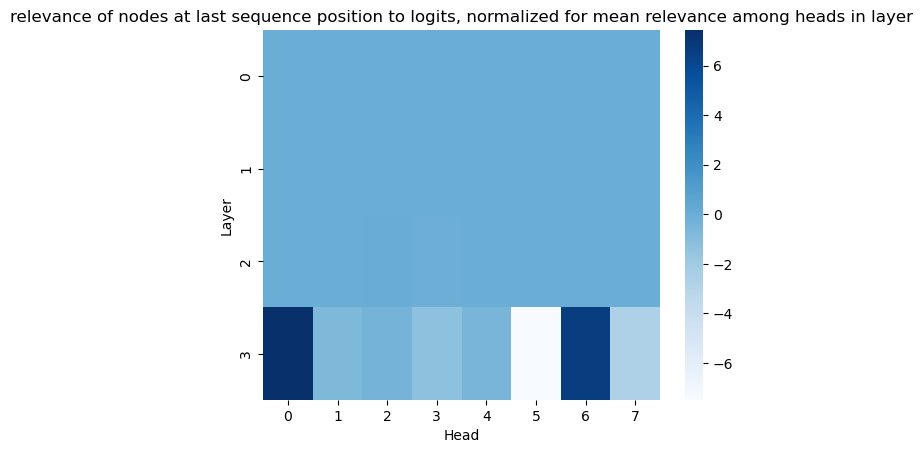

In [62]:

s = sns.heatmap(normalized_relevances[:, -1, :], xticklabels = range(num_attention_heads), yticklabels = range(num_layers), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
plt.title("relevance of nodes at last sequence position to logits, normalized for mean relevance among heads in layer")
plt.show()

In [75]:
for result in results[:20]:
    print(result)

Result(ablation_set=Node(layer_idx=3, sequence_idx=40, attn_head_idx=0), score=2.4325962)
Result(ablation_set=Node(layer_idx=3, sequence_idx=40, attn_head_idx=6), score=2.1737149)
Result(ablation_set=Node(layer_idx=2, sequence_idx=40, attn_head_idx=3), score=0.2628063)
Result(ablation_set=Node(layer_idx=1, sequence_idx=40, attn_head_idx=4), score=0.13904905)
Result(ablation_set=Node(layer_idx=0, sequence_idx=15, attn_head_idx=1), score=0.020195633)
Result(ablation_set=Node(layer_idx=1, sequence_idx=40, attn_head_idx=2), score=0.018609595)
Result(ablation_set=Node(layer_idx=2, sequence_idx=28, attn_head_idx=5), score=0.014143206)
Result(ablation_set=Node(layer_idx=0, sequence_idx=29, attn_head_idx=2), score=0.010294773)
Result(ablation_set=Node(layer_idx=0, sequence_idx=31, attn_head_idx=5), score=0.009637695)
Result(ablation_set=Node(layer_idx=1, sequence_idx=1, attn_head_idx=7), score=0.00550092)
Result(ablation_set=Node(layer_idx=1, sequence_idx=8, attn_head_idx=0), score=0.003200514

In [76]:
'''
Arg movers: 3.0, 3.6 at last position
Induction: 1.4 at last position
Prev token: 0.2 at B_doc, or the one after?
Prev token: 2.0 at C_def
Prev token: 1.4 at the fourth comma??

Also 0.5 at B_def, C_def and B_doc, 0.4 relevant to 1.4, 1.2.
'''

'\nArg movers: 3.0, 3.6 at last position\nInduction: 1.4 at last position\nPrev token: 0.2 at B_doc, or the one after?\n'

In [ ]:
results_per_iter = []
results_per_iter.append(results)

In [85]:
outliers = results[:2]

In [82]:
results[0].ablation_set[0]

Node(layer_idx=3, sequence_idx=40, attn_head_idx=0)

In [86]:
print(target_nodes)

[3, 3]


In [ ]:
ranges = [
        [layer for layer in range(num_layers)],
        [sequence_position for sequence_position in range(seq_len)],
        [attention_head_idx for attention_head_idx in range(num_attention_heads)]
]
source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

target_nodes = [outlier.ablation_set[0] for outlier in outliers]

# cache activations for faster batch run
# out_decomp, _, _, pre_layer_activations = prop_toy_model_4l(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=corrupt_attention_outputs, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_toy_model_4l(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=corrupt_attention_outputs, set_irrel_to_mean=True)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)

Running inputs 0 to 64 (of 1312)
Running inputs 64 to 128 (of 1312)
Running inputs 128 to 192 (of 1312)
Running inputs 192 to 256 (of 1312)
Running inputs 256 to 320 (of 1312)
Running inputs 320 to 384 (of 1312)
Running inputs 384 to 448 (of 1312)
Running inputs 448 to 512 (of 1312)
Running inputs 512 to 576 (of 1312)
Running inputs 576 to 640 (of 1312)
Running inputs 640 to 704 (of 1312)
Running inputs 704 to 768 (of 1312)
Running inputs 768 to 832 (of 1312)
Running inputs 832 to 896 (of 1312)
Running inputs 896 to 960 (of 1312)
Running inputs 960 to 1024 (of 1312)
Running inputs 1024 to 1088 (of 1312)
Running inputs 1088 to 1152 (of 1312)
Running inputs 1152 to 1216 (of 1312)
Running inputs 1216 to 1280 (of 1312)
Running inputs 1280 to 1312 (of 1312)


In [ ]:
relevances = np.zeros((num_layers, seq_len, num_attention_heads))
results = []
for layer_idx in range(num_layers):
    for seq_pos in range(seq_len):
        for head_idx in range(num_attention_heads):
            score = 0
            target_decomp = target_decomps[layer_idx * seq_len * num_attention_heads + seq_pos * num_attention_heads + head_idx]

            for i in range(len(target_decomp.target_nodes)):
                rels_magnitude = torch.mean(abs(target_decomp.rels[i])) # np.mean if you are on cpu
                irrels_magnitude = torch.mean(abs(target_decomp.irrels[i])) # np.mean if you are on cpu
                target_node_score = rels_magnitude / (rels_magnitude + irrels_magnitude)
                score += (target_node_score)
            if target_decomp.ablation_set[0] in target_nodes:
                score = 0
            relevances[layer_idx, seq_pos, head_idx] = score
            results.append(Result(decomp.ablation_set, score))

sums_per_layer = np.sum(relevances, axis=(1, 2))
sums_per_layer[sums_per_layer == 0] = -1e-8
normalized_relevances = relevances / np.expand_dims(sums_per_layer, (1, 2))
results.sort(key=operator.attrgetter('score'), reverse=True)

In [ ]:
s = sns.heatmap(normalized_relevances[:, -1, :], xticklabels = range(num_attention_heads), yticklabels = range(num_layers), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
plt.title("relevance of nodes at last sequence position to 'arg mover' heads, normalized")
plt.show()